#### Constellation plots

In [24]:
import scipy
import os
import sys

In [25]:
print(sys.path)

['', '/home/david/prefix-3.8/lib/python3/site-packages', '/home/david/prefix-3.8/lib/python3/dist-packages', '/home/david/prefix-3.8/lib/python3.6/site-packages', '/home/david/prefix-3.8/lib/python3.6/dist-packages', '/home/david/prefix-3.8/lib64/python3/site-packages', '/home/david/prefix-3.8/lib64/python3/dist-packages', '/home/david/prefix-3.8/lib64/python3.6/site-packages', '/home/david/prefix-3.8/lib64/python3.6/dist-packages', '/home/david/sigMF_ML/RF/RF_class', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/home/david/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/home/david/.local/lib/python3.6/site-packages/IPython/extensions', '/home/david/.ipython', '/home/david/DigiCommPy']


In [26]:
# sys.path.remove("/home/david/DigiCommPy")
sys.path.append("/home/david")

In [27]:
from DigiCommPy import modem

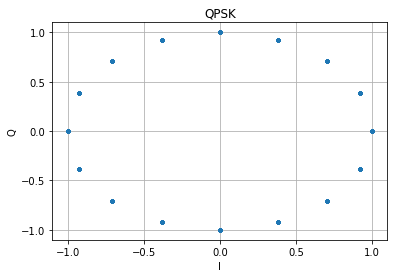

In [3]:
import numpy as np
import matplotlib.pyplot as plt

num_symbols = 1000
# plt.figure(figsize=(9, 6))
fig2 = plt.figure()
x_int = np.random.randint(0, 16, num_symbols) # 0 to 3
x_degrees = x_int*360/16.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
plt.plot(np.real(x_symbols), np.imag(x_symbols), '.')
# plt.legend(loc='center right')
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([-1, -.5, 0, .5, 1])
plt.title('QPSK')
plt.xlabel('I')
plt.ylabel('Q')
plt.grid(True)
plt.show()

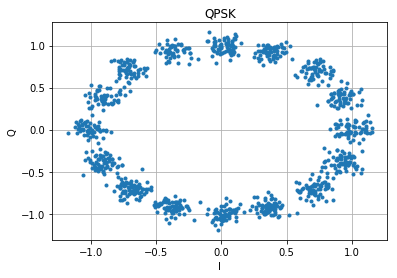

In [2]:
n = (np.random.randn(num_symbols) + 1j*np.random.randn(num_symbols))/np.sqrt(2) # AWGN with unity power
noise_power = 0.01
r = x_symbols + n * np.sqrt(noise_power)
plt.plot(np.real(r), np.imag(r), '.')
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([-1, -.5, 0, .5, 1])
plt.title('QPSK')
plt.xlabel('I')
plt.ylabel('Q')
plt.grid(True)
plt.show()

In [4]:
K = 6400 # number of OFDM subcarriers

In [5]:
CP = K//4  # length of the cyclic prefix: 25% of the block

In [6]:
P = 8 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits

allCarriers:   [   0    1    2 ... 6397 6398 6399]
pilotCarriers: [   0  800 1600 2400 3200 4000 4800 5600 6399]
dataCarriers:  [   1    2    3 ... 6396 6397 6398]


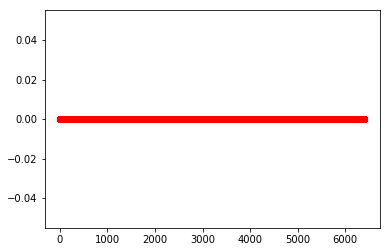

In [7]:
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')

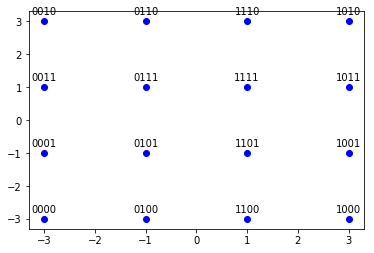

In [8]:
mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

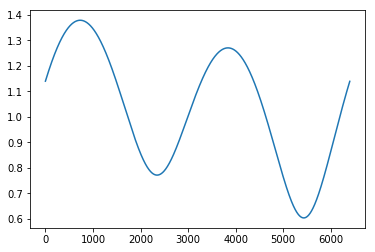

In [9]:
demapping_table = {v : k for k, v in mapping_table.items()}
# channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
channelResponse = np.array([1-0.1j, .0+0.1j, 0.1+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))

SNRdb = 10  # signal to noise-ratio in dB at the receiver 

In [10]:
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:20])
print ("Mean of bits (should be around 0.5): ", np.mean(bits))

Bits count:  25564
First 20 bits:  [1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1]
Mean of bits (should be around 0.5):  0.49616648411829134


In [11]:
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))
bits_SP = SP(bits)
print ("First 5 bit groups")
print (bits_SP[:5,:])

First 5 bit groups
[[1 0 1 1]
 [0 0 1 1]
 [1 0 1 1]
 [1 0 1 0]
 [0 1 1 1]]


In [12]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])

First 5 QAM symbols and bits:
[[1 0 1 1]
 [0 0 1 1]
 [1 0 1 1]
 [1 0 1 0]
 [0 1 1 1]]
[ 3.+1.j -3.+1.j  3.+1.j  3.+3.j -1.+1.j]


In [13]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(QAM)
print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))

Number of OFDM carriers in frequency domain:  6400


In [14]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

Number of OFDM samples in time-domain before CP:  6400


In [15]:
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

Number of OFDM samples in time domain with CP:  8000


In [16]:
SNRdb = 20

RX Signal power: 0.001749. Noise power: 0.000017


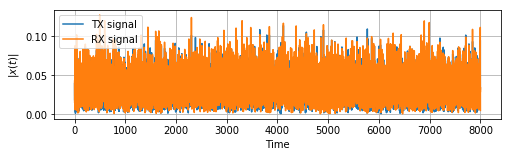

In [17]:
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    
    print ("RX Signal power: %.6f. Noise power: %.6f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

In [18]:
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX)

In [19]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

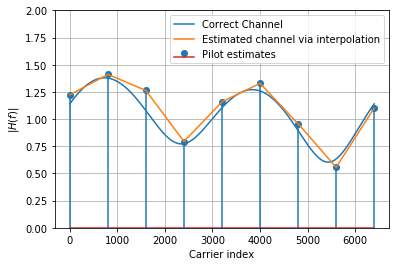

In [37]:
# import scipy
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    
    return Hest
Hest = channelEstimate(OFDM_demod)

In [38]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
def get_payload(equalized):
    return equalized[dataCarriers]

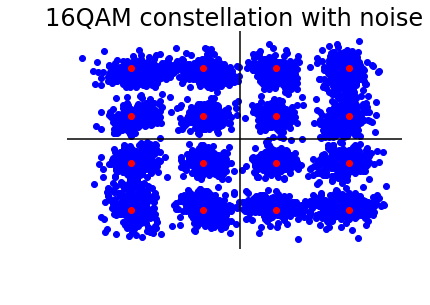

In [70]:
equalized_Hest = equalize(OFDM_demod, Hest)
QAM_est = get_payload(equalized_Hest)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(9, 6))
fig1 = plt.figure()
plt.plot(QAM_est.real, QAM_est.imag, 'bo', label='symbols');
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'ro')
#                 plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
# plt.legend(loc='center right')
plt.axvline(x=0, c="black")
plt.axhline(y=0, c="black")
plt.xticks([-4,-3,-2,-1,0,1,2,3,4])
plt.yticks([-4,-3,-2,-1,0,1,2,3,4])
plt.title('16QAM constellation with noise')
# plt.title('16QAM ideal constellation')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.axis('off')
fig1.savefig('16QAM_noise.pdf', format="pdf")

#### Demapping takes a while to run

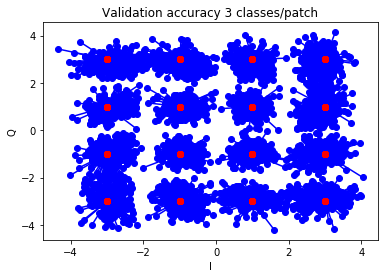

In [40]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, hardDecision = Demapping(QAM_est)
# plt.figure(figsize=(9, 6))
# fig1 = plt.figure()
# for qam, hard in zip(QAM_est, hardDecision):
#     plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
#     plt.plot(hardDecision.real, hardDecision.imag, 'ro')
# # plt.legend(loc='center right')
# plt.title('Validation accuracy 3 classes/patch')
# plt.xlabel('I')
# plt.ylabel('Q')
# fig1.savefig('16QAM_noise.pdf', format="pdf")
# plt.grid()

In [41]:
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)

In [42]:
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.003911750899702707


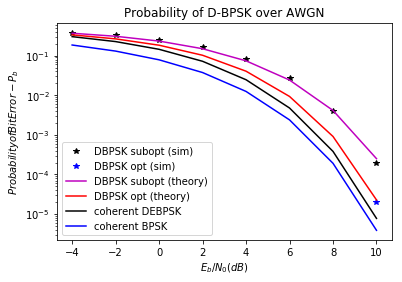

In [28]:
#Execute in Python3: exec(open("chapter_2/dbpsk_noncoherent.py").read())
import numpy as np #for numerical computing
import matplotlib.pyplot as plt #for plotting functions
from DigiCommPy.passband_modulations import bpsk_mod
from DigiCommPy.channels import awgn
from scipy.signal import lfilter
from scipy.special import erfc
N=100000 # Number of symbols to transmit
EbN0dB = np.arange(start=-4,stop = 11,step = 2) # Eb/N0 range in dB for simulation
L=8 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period)
# if a carrier is used, use L = Fs/Fc, where Fs >> 2xFc
Fc=800 # carrier frequency
Fs=L*Fc # sampling frequency
BER_suboptimum = np.zeros(len(EbN0dB)) # BER measures
BER_optimum = np.zeros(len(EbN0dB))
#-----------------Transmitter---------------------
ak = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
bk = lfilter([1.0],[1.0,-1.0],ak) # IIR filter for differential encoding
bk = bk%2 #XOR operation is equivalent to modulo-2
[s_bb,t]= bpsk_mod(bk,L) # BPSK modulation(waveform) - baseband
s = s_bb*np.cos(2*np.pi*Fc*t/Fs).astype(complex) # DBPSK with carrier
for i,EbN0 in enumerate(EbN0dB):
    # Compute and add AWGN noise
    r = awgn(s,EbN0,L) # refer Chapter section 4.1
    #----------suboptimum receiver---------------
    p=np.real(r)*np.cos(2*np.pi*Fc*t/Fs) # demodulate to baseband using BPF
    w0= np.hstack((p,np.zeros(L))) # append L samples on one arm for equal lengths
    w1= np.hstack((np.zeros(L),p)) # delay the other arm by Tb (L samples)
    w = w0*w1 # multiplier
    z = np.convolve(w,np.ones(L)) #integrator from kTb to (K+1)Tb (L samples)
    u = z[L-1:-1-L:L] # sampler t=kTb
    ak_hat = (u<0) #decision
    BER_suboptimum[i] = np.sum(ak!=ak_hat)/N #BER for suboptimum receiver
#-----------optimum receiver--------------
p=np.real(r)*np.cos(2*np.pi*Fc*t/Fs); # multiply I arm by cos
q=np.imag(r)*np.sin(2*np.pi*Fc*t/Fs) # multiply Q arm by sin
x = np.convolve(p,np.ones(L)) # integrate I-arm by Tb duration (L samples)
y = np.convolve(q,np.ones(L)) # integrate Q-arm by Tb duration (L samples)
xk = x[L-1:-1:L] # Sample every Lth sample
yk = y[L-1:-1:L] # Sample every Lth sample
w0 = xk[0:-2] # non delayed version on I-arm
w1 = xk[1:-1] # 1 bit delay on I-arm
z0 = yk[0:-2] # non delayed version on Q-arm
z1 = yk[1:-1] # 1 bit delay on Q-arm
u =w0*w1 + z0*z1 # decision statistic
ak_hat=(u<0) # threshold detection
BER_optimum[i] = np.sum(ak[1:-1]!=ak_hat)/N # BER for optimum receiver
#------Theoretical Bit/Symbol Error Rates-------------
EbN0lins = 10**(EbN0dB/10) # converting dB values to linear scale
theory_DBPSK_optimum = 0.5*np.exp(-EbN0lins)
theory_DBPSK_suboptimum = 0.5*np.exp(-0.76*EbN0lins)
theory_DBPSK_coherent=erfc(np.sqrt(EbN0lins))*(1-0.5*erfc(np.sqrt(EbN0lins)))
theory_BPSK_conventional = 0.5*erfc(np.sqrt(EbN0lins))
#-------------Plotting---------------------------
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax.semilogy(EbN0dB,BER_suboptimum,'k*',label='DBPSK subopt (sim)')
ax.semilogy(EbN0dB,BER_optimum,'b*',label='DBPSK opt (sim)')
ax.semilogy(EbN0dB,theory_DBPSK_suboptimum,'m-',label='DBPSK subopt (theory)')
ax.semilogy(EbN0dB,theory_DBPSK_optimum,'r-',label='DBPSK opt (theory)')
ax.semilogy(EbN0dB,theory_DBPSK_coherent,'k-',label='coherent DEBPSK')
ax.semilogy(EbN0dB,theory_BPSK_conventional,'b-',label='coherent BPSK')
ax.set_title('Probability of D-BPSK over AWGN')
ax.set_xlabel('$E_b/N_0 (dB)$');ax.set_ylabel('$Probability of Bit Error - P_b$')
ax.legend();
# fig.show()

In [29]:
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    Parameters:
    s : input/transmitted signal vector
    SNRdB : desired signal to noise ratio (expressed in dB)
    for the received signal
    L : oversampling factor (applicable for waveform simulation)
    default L = 1.
    Returns:
    r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal
    return r

Text(0.5,1,'IQ noise')

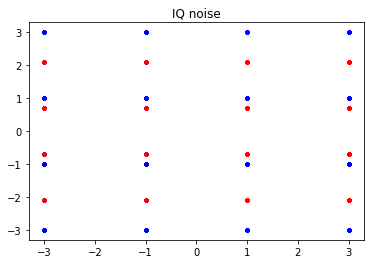

In [34]:
import numpy as np #for numerical computing
import matplotlib.pyplot as plt #for plotting functions
from DigiCommPy import modem
#from DigiCommPy.modem import plotConstellation
M=16 # M-QAM modulation order
nSym=1000 # To generate random symbols
# uniform random symbols from 0 to M-1
inputSyms = np.random.randint(low=0, high = M, size=nSym)
modem = QAMModem(M) # initialize the M-QAM modem object
s = modem.modulate(inputSyms) # modulated sequence

from DigiCommPy import impairments
from DigiCommPy.channels import awgn
Q = awgn(s, 30, L=10)
r1 = impModel_1.receiver_impairments(s)
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax.plot(real(s),imag(s),'b.')
ax.plot(real(r1),imag(r1),'r.');ax.set_title('IQ noise')


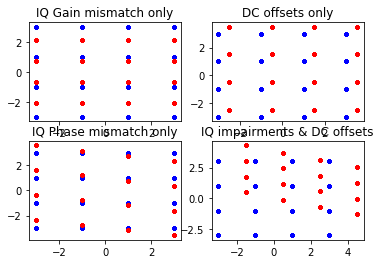

In [35]:
import numpy as np #for numerical computing
from numpy import real,imag
from DigiCommPy.modem import QAMModem #QAM Modem model
from DigiCommPy.impairments import ImpairmentModel #Impairment Model
import matplotlib.pyplot as plt #for plotting functions
M=16 # M-QAM modulation order
nSym=1000 # To generate random symbols
# uniform random symbols from 0 to M-1
inputSyms = np.random.randint(low=0, high = M, size=nSym)
modem = QAMModem(M) # initialize the M-QAM modem object
s = modem.modulate(inputSyms) # modulated sequence
impModel_1 = ImpairmentModel(g=0.7) # gain mismatch only model
impModel_2 = ImpairmentModel(phi=12) # phase mismatch only model
impModel_3 = ImpairmentModel(dc_i=0.5,dc_q=0.5) # DC offsets only
impModel_4 = ImpairmentModel(g=0.7,phi=25,dc_i=1.5,dc_q=1.5) # All impairments
#Add impairments to the input signal sequence using the models
r1 = impModel_1.receiver_impairments(s)
r2 = impModel_2.receiver_impairments(s)
r3 = impModel_3.receiver_impairments(s)
r4 = impModel_4.receiver_impairments(s)
fig, ax = plt.subplots(nrows=2,ncols = 2)
ax[0,0].plot(real(s),imag(s),'b.')
ax[0,0].plot(real(r1),imag(r1),'r.');ax[0,0].set_title('IQ Gain mismatch only')
ax[0,1].plot(real(s),imag(s),'b.')
ax[0,1].plot(real(r3),imag(r3),'r.');ax[0,1].set_title('DC offsets only')
ax[1,0].plot(real(s),imag(s),'b.')
ax[1,0].plot(real(r2),imag(r2),'r.');ax[1,0].set_title('IQ Phase mismatch only')
ax[1,1].plot(real(s),imag(s),'b.')
ax[1,1].plot(real(r4),imag(r4),'r.')
ax[1,1].set_title('IQ impairments & DC offsets');fig.show()

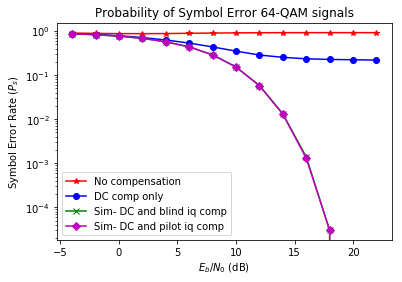

In [32]:
import numpy as np # for numerical computing
from DigiCommPy.modem import QAMModem #QAM Modem model
from DigiCommPy.channels import awgn
from DigiCommPy.impairments import ImpairmentModel #Impairment Model
from DigiCommPy.compensation import dc_compensation,blind_iq_compensation,PilotEstComp
from DigiCommPy.errorRates import ser_awgn
import matplotlib.pyplot as plt #for plotting functions
# ---------Input Fields------------------------
nSym=100000 # Number of input symbols
EbN0dBs = np.arange(start=-4, stop=24, step=2) # Define EbN0dB range for simulation
M=64 # M-QAM modulation order
g=0.9; phi=8; dc_i=1.9; dc_q=1.7 # receiver impairments
# ----------------------------------------------
k=np.log2(M)
EsN0dBs = 10*np.log10(k)+EbN0dBs # EsN0dB calculation

SER_1 = np.zeros(len(EbN0dBs)) # Symbol Error rates (No compensation)
SER_2 = np.zeros(len(EbN0dBs)) # Symbol Error rates (DC compensation only)
SER_3 = np.zeros(len(EbN0dBs)) # Symbol Error rates (DC comp & Blind IQ comp)
SER_4 = np.zeros(len(EbN0dBs)) # Symbol Error rates (DC comp & Pilot IQ comp)

d = np.random.randint(low=0, high = M, size=nSym) # random symbols from 0 to M-1
modem = QAMModem(M) #initialize the M-QAM modem object
modulatedSyms = modem.modulate(d) #modulated sequence

for i,EsN0dB in enumerate(EsN0dBs):
    receivedSyms = awgn(modulatedSyms,EsN0dB) # add awgn nois
    impObj = ImpairmentModel(g,phi,dc_i,dc_q) # init impairments model
    y1 = impObj.receiver_impairments(receivedSyms) # add impairments
    y2 = dc_compensation(y1) # DC compensation
    #Through Blind IQ compensation after DC compensation
    y3 = blind_iq_compensation(y2)
    #Through Pilot estimation and compensation model
    pltEstCompObj = PilotEstComp(impObj) #initialize
    y4 = pltEstCompObj.pilot_iqImb_compensation(y1) #call function
    """
    Enable this section - if you want to plot constellation diagram
    fig1, ax = plt.subplots(nrows = 1,ncols = 1)
    ax.plot(np.real(y1),np.imag(y1),'r.')
    ax.plot(np.real(y4),np.imag(y4),'b*')
    ax.set_title('$E_b/N_0$={} (dB)'.format(EbN0dBs[i]));
    fig1.show();input()
    """
    # -------IQ Detectors--------
    dcap_1 = modem.iqDetector(y1) # No compensation
    dcap_2 = modem.iqDetector(y2) # DC compensation only
    dcap_3 = modem.iqDetector(y3) # DC & blind IQ comp.
    dcap_4 = modem.iqDetector(y4) # DC & pilot IQ comp.
    # ------ Symbol Error Rate Computation-------
    SER_1[i]=sum((d!=dcap_1))/nSym; SER_2[i]=sum((d!=dcap_2))/nSym
    SER_3[i]=sum((d!=dcap_3))/nSym; SER_4[i]=sum((d!=dcap_4))/nSym

SER_theory = ser_awgn(EbN0dBs,'QAM',M) #theory SER
fig2, ax = plt.subplots(nrows = 1,ncols = 1)
ax.semilogy(EbN0dBs,SER_1,'*-r',label='No compensation')
ax.semilogy(EbN0dBs,SER_2,'o-b',label='DC comp only')
ax.semilogy(EbN0dBs,SER_3,'x-g',label='Sim- DC and blind iq comp') 
ax.semilogy(EbN0dBs,SER_4,'D-m',label='Sim- DC and pilot iq comp')
#ax.semilogy(EbN0dBs,SER_theory,'k',label='Theoretical')
ax.set_xlabel('$E_b/N_0$ (dB)');ax.set_ylabel('Symbol Error Rate ($P_s$)')
ax.set_title('Probability of Symbol Error 64-QAM signals');
ax.legend();fig2.show()

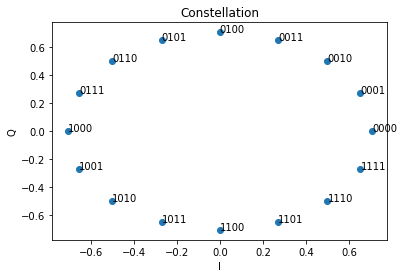

In [33]:
from DigiCommPy.modem import PSKModem
M = 16 #16 points in the constellation
pskModem = PSKModem(M) #create a 16-PSK modem object
pskModem.plotConstellation() #plot ideal constellation for this modem
import numpy as np # for numerical computing
nSym = 100 #10 symbols as input to PSK modem
inputSyms = np.random.randint(low=0, high = M, size=nSym) # uniform random
modulatedSyms = pskModem.modulate(inputSyms) #modulate
detectedSyms = pskModem.demodulate(modulatedSyms) #demodul